<a href="https://colab.research.google.com/github/squadledge/SharkSpotting/blob/master/FindJaws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
from os import listdir
from os.path import splitext
from google.colab import drive
from xml.etree import ElementTree
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import numpy as np
import cv2
import math
import sys
import time
#import xml stuff to extract bounding boxes

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
class SharkDataset(torch.utils.data.Dataset):
    def __init__(self, root = "drive/My Drive/shark-project", transforms = torchvision.transforms.ToTensor()):
        self.rootdir = root
        self.images_dir = "drive/My Drive/shark-project/images/"
        self.labels_dir = "drive/My Drive/shark-project/labels/"
        self.transforms = transforms
        self.imgs = [self.images_dir + i for i in listdir(self.images_dir)]
        self.annotations = [self.labels_dir + splitext(i)[0] + ".xml" for i in listdir(self.images_dir)]

    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        "Returns the image (tensor), and target {boxes, labels}"
        target = {}
        im = self.imgs[idx]
        lbl = self.annotations[idx]
        im = self.transforms(cv2.imread(im))
        boxes = self.extract_boxes(lbl)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target['boxes'] = boxes
        target['labels'] = torch.ones([len(boxes)], dtype=torch.int64)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        return (im, target)

    def extract_boxes(self, label):
        tree = ElementTree.parse(label)
        root = tree.getroot()
        boxes = []
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
		# extract image dimensions
        #width = int(root.find('.//size/width').text)
        #height = int(root.find('.//size/height').text)
        if(len(boxes) == 0):
			# attempt alternate format parsing
            boxes = []
            for box in root.findall('.//polygon'):
                xs = []
                ys = []
                for pt in box.findall('./pt'):
                    xs.append(int(pt.find('x').text))
                    ys.append(int(pt.find('y').text))
                xmin = min(xs)
                xmax = max(xs)
                ymin = min(ys)
                ymax = max(ys)
                coors = [xmin, ymin, xmax, ymax]
                boxes.append(coors)
        boxes = torch.tensor(boxes)
        return boxes.reshape(-1, 4)

def show_boxes(im,boxes):
    im = im.permute(1, 2, 0)
    pyplot.title('Test')
    pyplot.imshow(im)
    ax = pyplot.gca()
    for box in boxes:
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill = False, color='red')
        ax.add_patch(rect)
    pyplot.show()      


In [5]:
#reset layers
#Set Up Transfer Learning
num_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:

# #Example Forward Pass
# # dataset = SharkDataset()
# # sample = dataset[1234]
# # print(sample[1]['boxes'])
# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     return [data, target]

# model.train()
# dataset = SharkDataset()
# # sample = dataset[200]
# # print(sample[1]['boxes'].shape)
# data_loader = torch.utils.data.DataLoader(
# dataset, shuffle=True, batch_size = 2, collate_fn = my_collate)

# i = 0
# while (i < 2000):
#     try:
#         images, targets = next(iter(data_loader))
#         images = list(image for image in images)
#         targets = [{k: v for k, v in t.items()} for t in targets]
#         output = model(images,targets)
#         print(output)
#         i = i + 1
#     except:
#         show_boxes(images[0],targets[0]['boxes'])
#         show_boxes(images[1],targets[1]['boxes'])


In [7]:
from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [9]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [10]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

dataset = SharkDataset()
dataset_test = SharkDataset()

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-300])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-300:])
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle=True, collate_fn=my_collate)
data_test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle=True)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9,weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    #evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [  0/138]  eta: 0:02:43  lr: 0.000041  loss: 1.1223 (1.1223)  loss_classifier: 1.0259 (1.0259)  loss_box_reg: 0.0730 (0.0730)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 1.1822  data: 0.0888  max mem: 7159
Epoch: [0]  [ 10/138]  eta: 0:02:29  lr: 0.000406  loss: 0.7021 (0.7106)  loss_classifier: 0.5850 (0.5850)  loss_box_reg: 0.0771 (0.0786)  loss_objectness: 0.0328 (0.0406)  loss_rpn_box_reg: 0.0069 (0.0063)  time: 1.1642  data: 0.0907  max mem: 7428
Epoch: [0]  [ 20/138]  eta: 0:02:17  lr: 0.000771  loss: 0.4259 (0.5482)  loss_classifier: 0.2182 (0.3993)  loss_box_reg: 0.0811 (0.0901)  loss_objectness: 0.0376 (0.0502)  loss_rpn_box_reg: 0.0073 (0.0086)  time: 1.1605  data: 0.0896  max mem: 7428
Epoch: [0]  [ 30/138]  eta: 0:02:05  lr: 0.001135  loss: 0.3439 (0.4654)  loss_classifier: 0.1674 (0.3211)  loss_box_reg: 0.0988 (0.0933)  loss_objectness: 0.0310 (0.0428)  loss_rpn_box_reg: 0.0080 (0.0081)  time: 1.1585  data: 0.0881  max mem: 7428


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


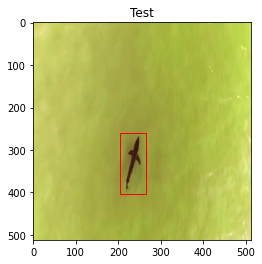

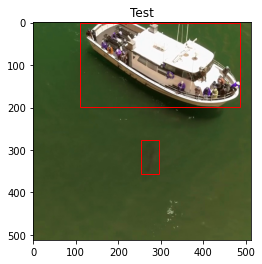

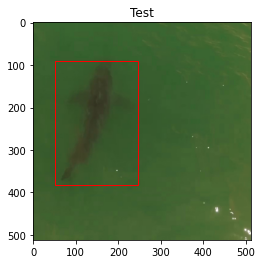

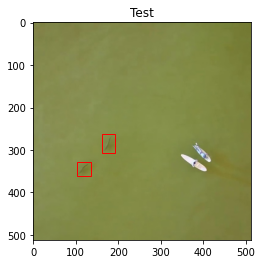

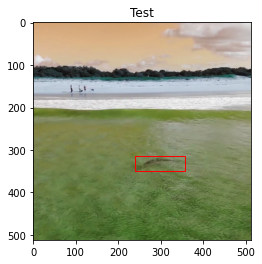

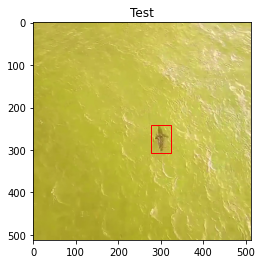

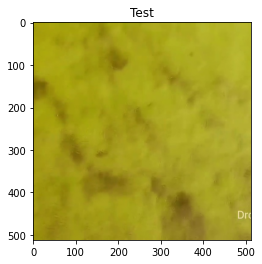

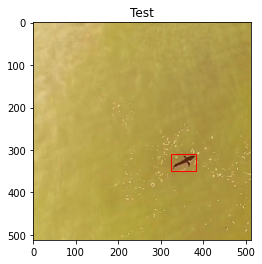

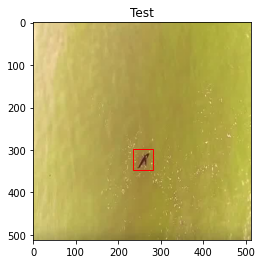

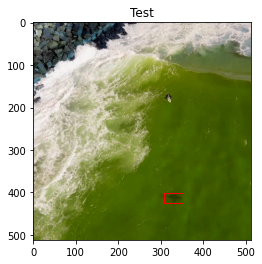

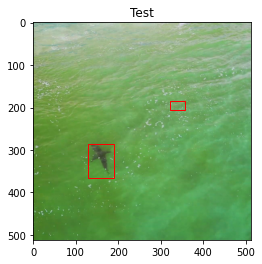

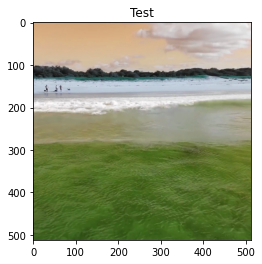

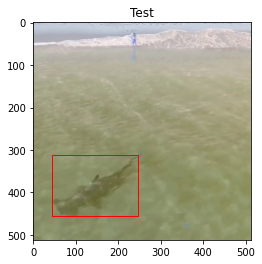

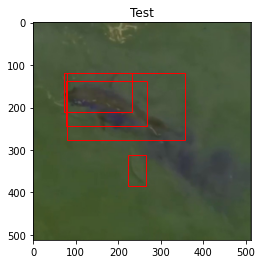

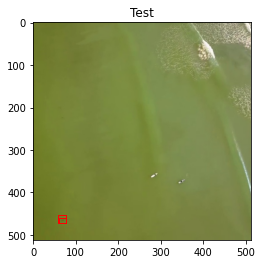

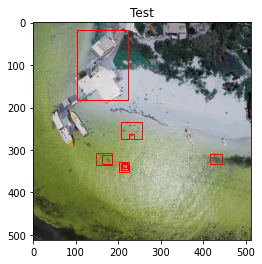

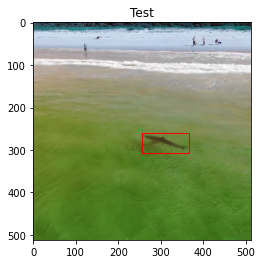

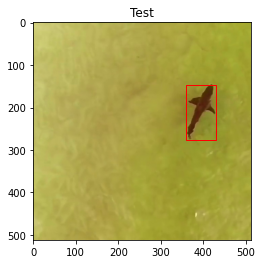

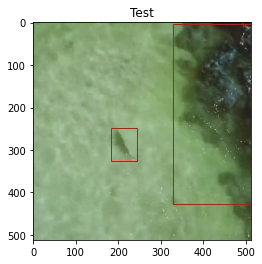

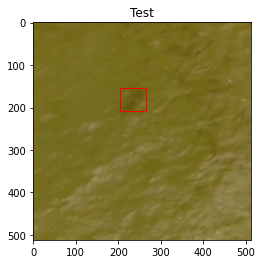

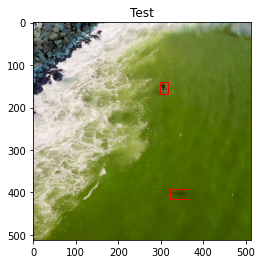

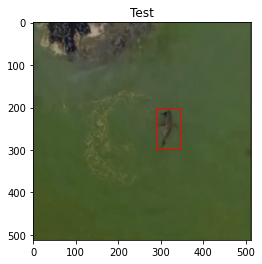

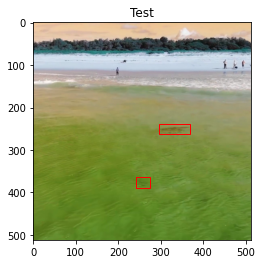

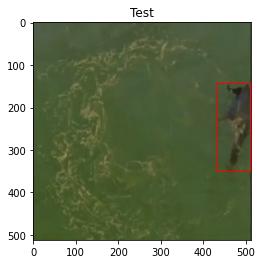

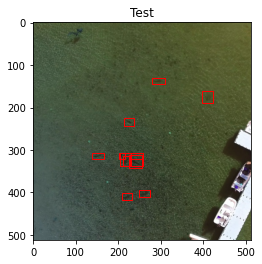

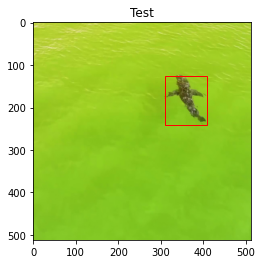

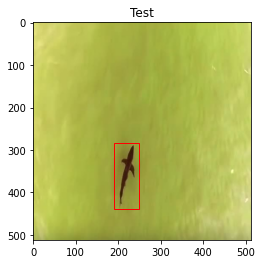

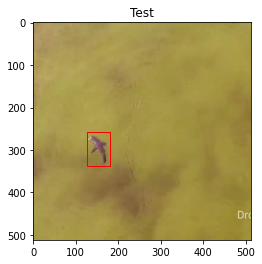

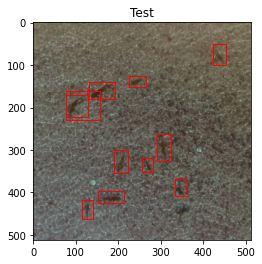

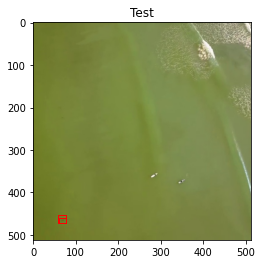

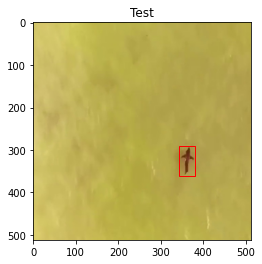

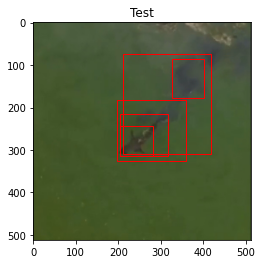

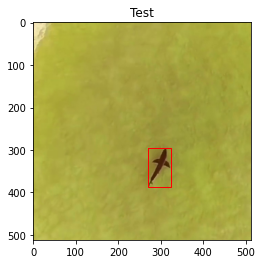

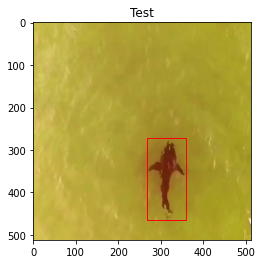

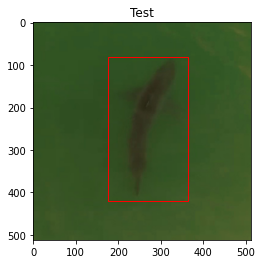

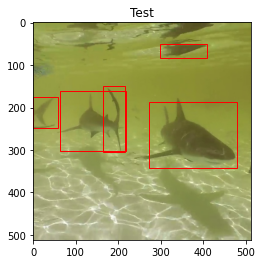

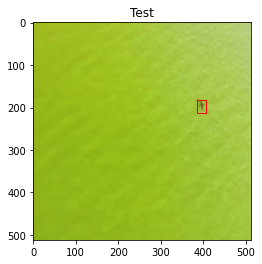

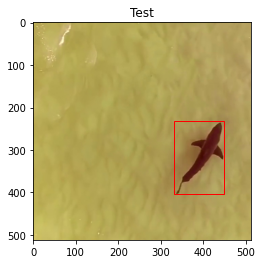

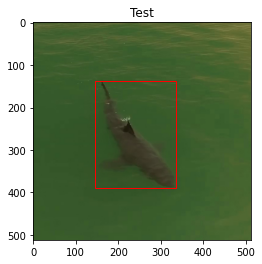

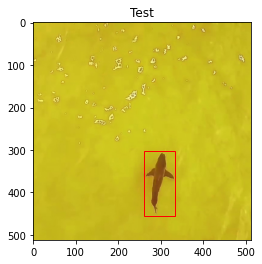

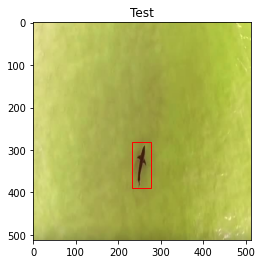

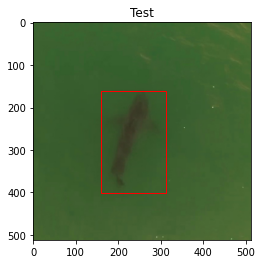

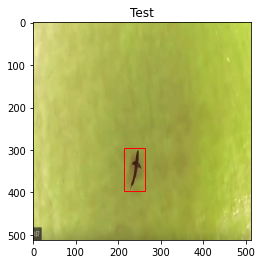

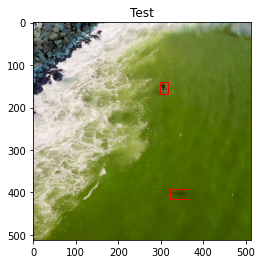

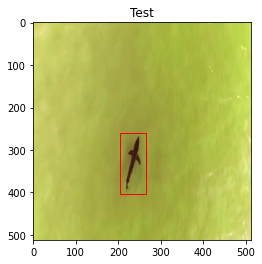

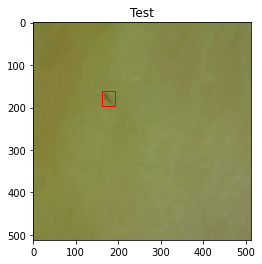

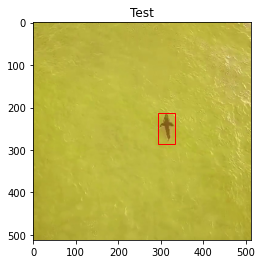

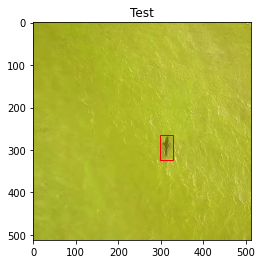

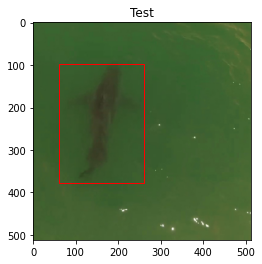

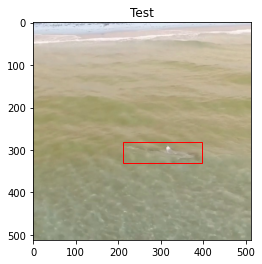

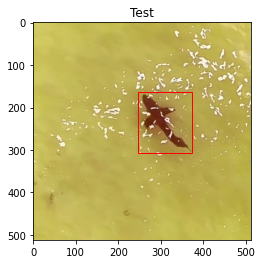

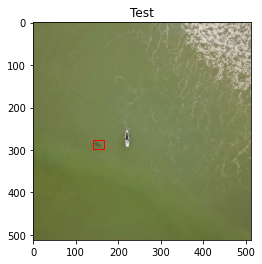

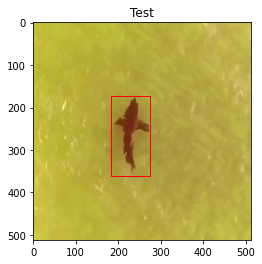

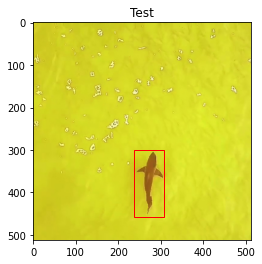

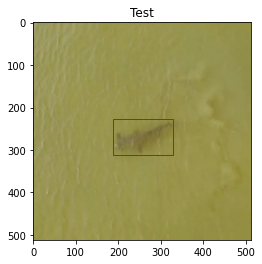

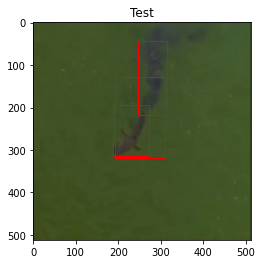

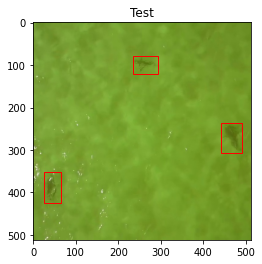

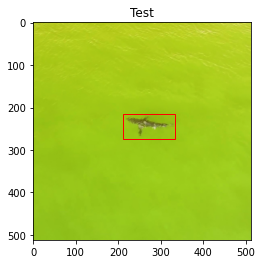

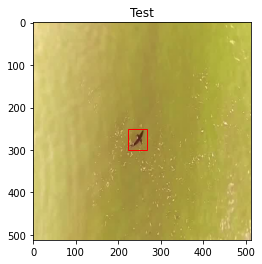

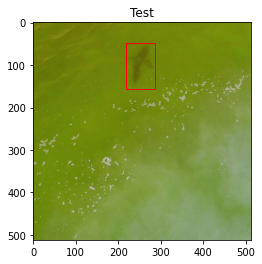

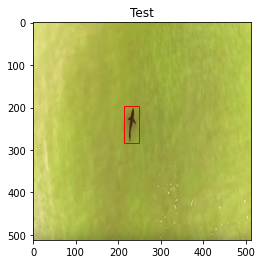

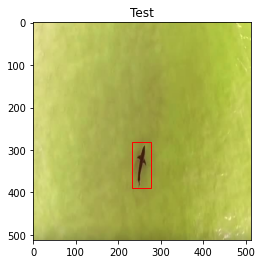

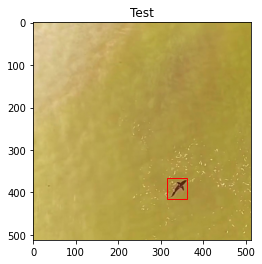

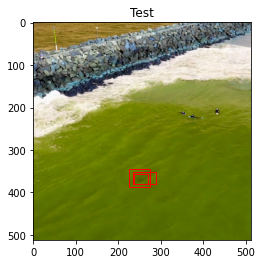

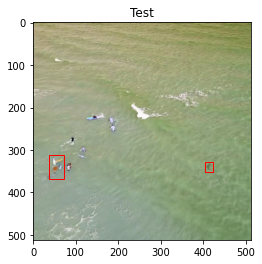

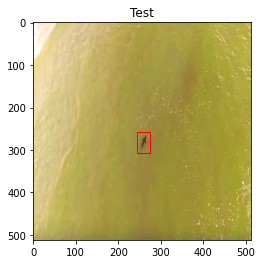

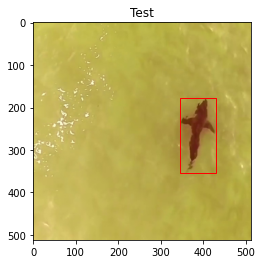

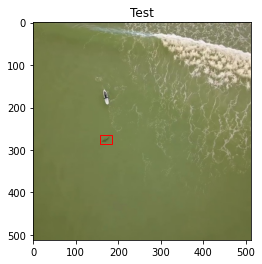

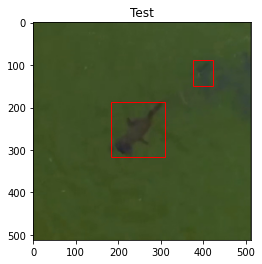

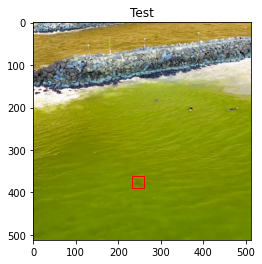

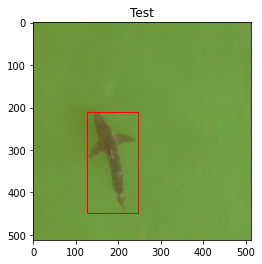

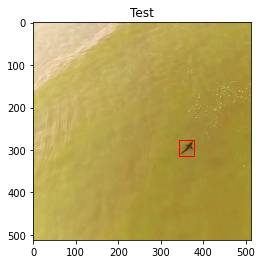

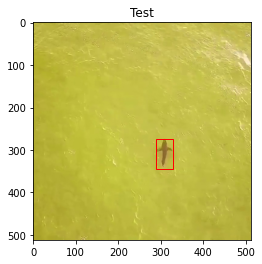

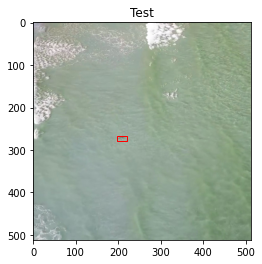

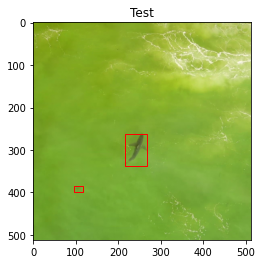

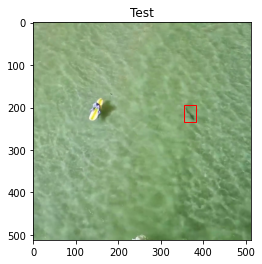

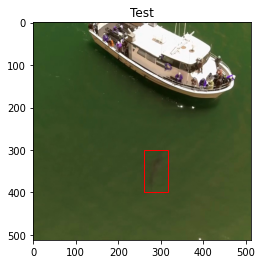

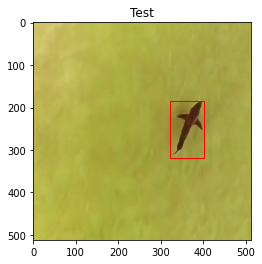

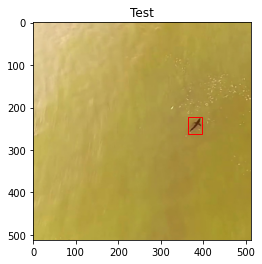

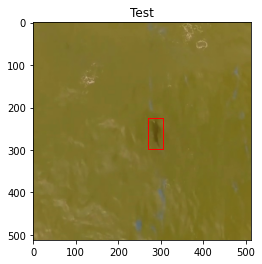

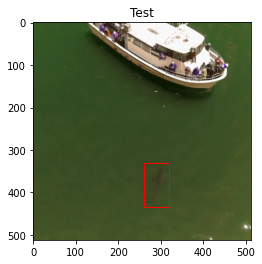

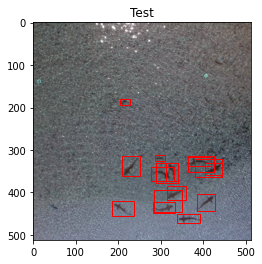

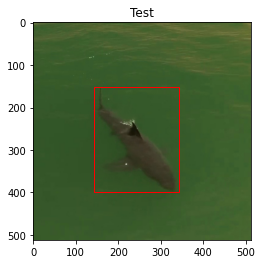

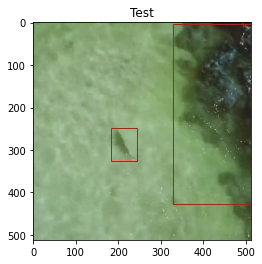

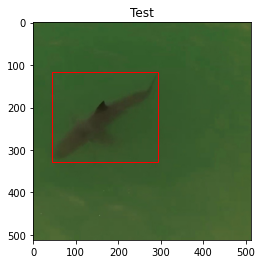

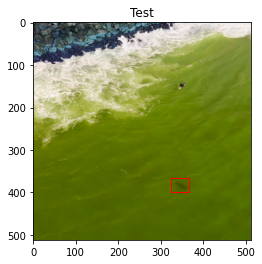

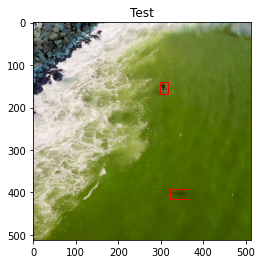

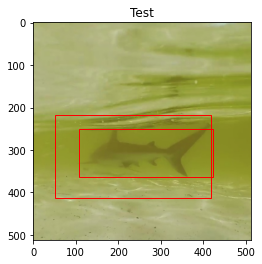

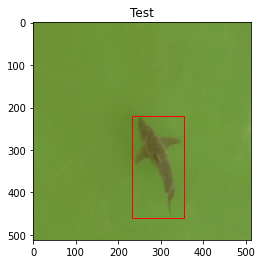

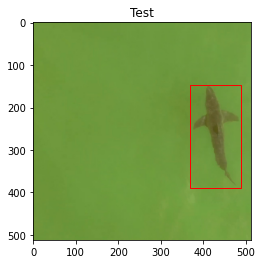

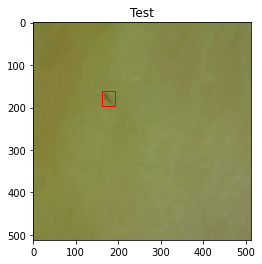

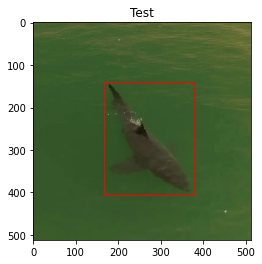

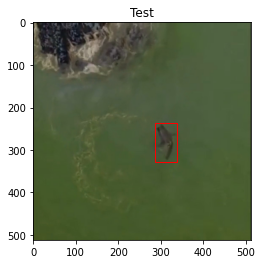

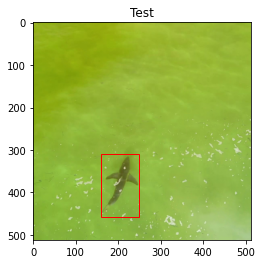

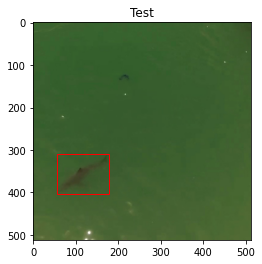

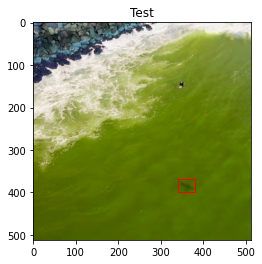

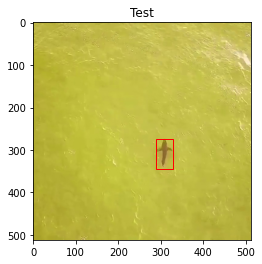

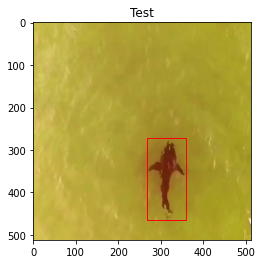

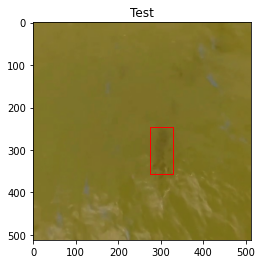

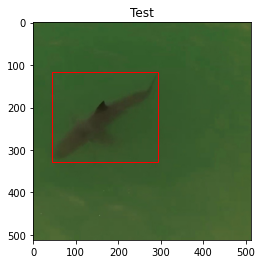

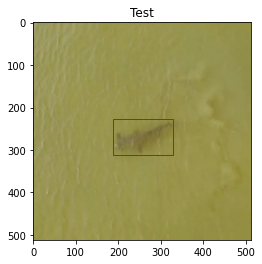

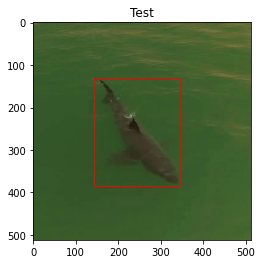

In [ ]:
try:
    while(1):
        sample = next(iter(data_test_loader))
        images, targets = sample
        x = images.cuda()
        model.eval()
        ans = model(x)
        show_boxes(images[0], ans[0]['boxes'])
except:
    print("done")

In [1]:
# import the necessary packages
from imutils.video import VideoStream
from imutils.video import FPS
import argparse
import imutils
import time
import cv2

ap = argparse.ArgumentParser()
ap.add_argument("-v", "--video", type=str,
	help="path to input video file")
ap.add_argument("-t", "--tracker", type=str, default="kcf",
	help="OpenCV object tracker type")
args = vars(ap.parse_args())

# initialize a dictionary that maps strings to their corresponding
# OpenCV object tracker implementations
OPENCV_OBJECT_TRACKERS = {
	"csrt": cv2.TrackerCSRT_create,
	"kcf": cv2.TrackerKCF_create,
	"boosting": cv2.TrackerBoosting_create,
	"mil": cv2.TrackerMIL_create,
	"tld": cv2.TrackerTLD_create,
	"medianflow": cv2.TrackerMedianFlow_create,
	"mosse": cv2.TrackerMOSSE_create
}
# grab the appropriate object tracker using our dictionary of
# OpenCV object tracker objects
tracker = OPENCV_OBJECT_TRACKERS[args["tracker"]]()
# initialize the bounding box coordinates of the object we are going
# to track
initBB = None
# if a video path was not supplied, grab the reference to the web cam
if not args.get("video", False):
	print("[INFO] starting video stream...")
	vs = VideoStream(src=0).start()
	time.sleep(1.0)
# otherwise, grab a reference to the video file
else:
	vs = cv2.VideoCapture(args["video"])
# initialize the FPS throughput estimator
fps = None

# loop over frames from the video stream
while True:
	# grab the current frame, then handle if we are using a
	# VideoStream or VideoCapture object
	frame = vs.read()
	frame = frame[1] if args.get("video", False) else frame
	# check to see if we have reached the end of the stream
	if frame is None:
		break
	# resize the frame (so we can process it faster) and grab the
	# frame dimensions
	frame = imutils.resize(frame, width=500)
	(H, W) = frame.shape[:2]

	# check to see if we are currently tracking an object
	if initBB is not None:
		# grab the new bounding box coordinates of the object
		(success, box) = tracker.update(frame)
		# check to see if the tracking was a success
		if success:
			(x, y, w, h) = [int(v) for v in box]
			cv2.rectangle(frame, (x, y), (x + w, y + h),
				(0, 255, 0), 2)
		# update the FPS counter
		fps.update()
		fps.stop()
		# initialize the set of information we'll be displaying on
		# the frame
		info = [
			("Tracker", args["tracker"]),
			("Success", "Yes" if success else "No"),
			("FPS", "{:.2f}".format(fps.fps())),
		]
		# loop over the info tuples and draw them on our frame
		for (i, (k, v)) in enumerate(info):
			text = "{}: {}".format(k, v)
			cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
				cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	# if the 's' key is selected, we are going to "select" a bounding
	# box to track
	if key == ord("s"):
		# select the bounding box of the object we want to track (make
		# sure you press ENTER or SPACE after selecting the ROI)
		initBB = cv2.selectROI("Frame", frame, fromCenter=False,
			showCrosshair=True)
		# start OpenCV object tracker using the supplied bounding box
		# coordinates, then start the FPS throughput estimator as well
		tracker.init(frame, initBB)
		fps = FPS().start()
	elif key == ord("q"):
		break
if not args.get("video", False):
	vs.stop()
else:
	vs.release()

cv2.destroyAllWindows()

usage: ipykernel_launcher.py [-h] [-v VIDEO] [-t TRACKER]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-3af23e06-58f3-46ed-bcc3-0270567fb525.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
